# Alz vs. Healthy Classifier

## Imports

In [1]:
import os
import numpy as np
import pandas as pd
import mne
import warnings

from mne import make_fixed_length_epochs
from mne.decoding import CSP
from mne.io import read_raw_eeglab
from scipy.signal import welch

In [2]:
participants_path = 'dataset/participants.tsv'
participants_df = pd.read_csv(participants_path, sep='\t')

print(participants_df.columns)
participants_df.head()

Index(['participant_id', 'Gender', 'Age', 'Group', 'MMSE'], dtype='object')


,participant_id,Gender,Age,Group,MMSE
0,sub-001,F,57,A,16
1,sub-002,F,78,A,22
2,sub-003,M,70,A,14
3,sub-004,F,67,A,20
4,sub-005,M,70,A,22


## Clearing MNE Warnings

In [3]:
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)


mne.set_log_level('WARNING')

## Grabbing Features & Loading Data

We defined brainwave frequency bands that will be used for the power feature extraction function we developed. These are pretty common EEG bands that carry meaningful neurophysiological information usually and we will use it for our model.

In [4]:
FREQ_BANDS = {
    "alpha": (8, 13),
    "beta": (13, 30),
    "gamma": (30, 45)
}

This function loads in data from participants that are either healthy or have Alz, filtering out participants with FTD and making sure to attach subject labels and ID.

In [5]:
def load_eeg_data(participants_df, base_dir):
    eeg_data = []
    for _, row in participants_df.iterrows():
        subject_id = row['participant_id']
        label = row['label']

        subject_folder = os.path.join(base_dir, subject_id, 'eeg')
        set_filename = f'{subject_id}_task-eyesclosed_eeg.set'
        set_filepath = os.path.join(subject_folder, set_filename)

        if os.path.exists(set_filepath):
            try:
                raw = mne.io.read_raw_eeglab(set_filepath, preload=True)
                eeg_data.append((raw, label, subject_id))
                print(f"✅ Loaded {subject_id} (label: {label})")
            except Exception as e:
                print(f"❌ Failed to load {subject_id}: {e}")
        else:
            print(f"⚠️ File not found: {set_filepath}")
    return eeg_data

This function applies bandpass filtering (1–45 Hz) and 60 Hz notch filtering to get rid some of the noise and artifacts from each subject's EEG. It returns a list of clean, raw EEG objects, ready for feature extraction.

In [6]:
def preprocess_raws(raw_list, l_freq=1.0, h_freq=45.0, notch_freq=60.0):
    filtered_raws = []
    for raw in raw_list:
        raw_filt = raw.copy()
        raw_filt.filter(l_freq=l_freq, h_freq=h_freq, verbose=False)
        raw_filt.notch_filter(freqs=notch_freq, verbose=False)
        filtered_raws.append(raw_filt)
    return filtered_raws

This function splits each subject’s EEG data into fixed len (e.g. 1 sec) epochs and makes sure that we have  consistent shape across subjects.

In [7]:
def extract_fixed_epochs(raw_list, duration=1.0):
    epochs_list = []
    expected_shape = None

    for raw in raw_list:
        epochs = make_fixed_length_epochs(raw, duration=duration, overlap=0, preload=True, verbose=False)
        sfreq = raw.info['sfreq']
        n_samples = int(sfreq * duration)
        data = epochs.get_data(copy=True)[:, :, :n_samples]

        epoch = data[0]
        if expected_shape is None:
            expected_shape = epoch.shape
        if epoch.shape != expected_shape:
            print(f"⚠️ Skipping subject with shape {epoch.shape}, expected {expected_shape}")
            continue

        epochs_list.append(epoch)

    return np.stack(epochs_list)

For each subject / channel, this function computes avg power within the EEG freq bands above (alpha, beta, gamma) using welch’s method. It returns a matrix of band power features with one row per subject.

In [8]:
def extract_band_powers(X, sfreq):
    band_power_features = []
    for subject in X:
        subject_features = []
        for ch_idx in range(subject.shape[0]):
            freqs, psd = welch(subject[ch_idx], sfreq, nperseg=int(sfreq * 2))
            for fmin, fmax in FREQ_BANDS.values():
                idx_band = np.logical_and(freqs >= fmin, freqs <= fmax)
                band_power = np.mean(psd[idx_band])
                subject_features.append(band_power)
        band_power_features.append(subject_features)
    return np.array(band_power_features)

This function calcs the ratio of alpha to beta power for each channel of each subject, which can show us cognitive processing differences. It returns a matrix of alpha/beta ratios per subject.

In [9]:
def extract_alpha_beta_ratios(X, sfreq):
    ratio_features = []
    for subject in X:
        subject_ratios = []
        for ch_idx in range(subject.shape[0]):
            freqs, psd = welch(subject[ch_idx], sfreq, nperseg=int(sfreq * 2))
            alpha_idx = np.logical_and(freqs >= 8, freqs <= 13)
            beta_idx = np.logical_and(freqs >= 13, freqs <= 30)
            alpha_power = np.mean(psd[alpha_idx])
            beta_power = np.mean(psd[beta_idx])
            ratio = alpha_power / beta_power if beta_power > 0 else 0
            subject_ratios.append(ratio)
        ratio_features.append(subject_ratios)
    return np.array(ratio_features)

This function gets the  Common Spatial Pattern (CSP) features that maximize variance between Alz and healthy groups. It returns a reduced set of spatially-discriminative features for each subject.

In [10]:
def extract_csp_features(X, y, n_components=4):
    X_reshaped = X.reshape(X.shape[0], X.shape[1], X.shape[2])
    csp = CSP(n_components=n_components, log=True, norm_trace=False)
    csp_feats = csp.fit_transform(X_reshaped, y)
    return csp_feats

This function brings everything together with preprocessing, epoching, and feature extraction (band power, ratios, CSP). It returns an easy to use complete DataFrame where each row represents a subject and includes all  features, the label, and subject ID. This will allow us to train a model easier given the complicated data structure

In [11]:
def extract_all_features(eeg_data, epoch_duration=1.0):
    raws = [raw for raw, label, subj_id in eeg_data]
    y = np.array([label for raw, label, subj_id in eeg_data])
    subjects = [subj_id for raw, label, subj_id in eeg_data]

    raws_filt = preprocess_raws(raws)
    sfreq = raws_filt[0].info['sfreq']
    epochs = extract_fixed_epochs(raws_filt, duration=epoch_duration)
    X = epochs

    used_indices = list(range(len(subjects)))
    if len(X) < len(subjects):
        print(f"⚠️ Using only {len(X)} of {len(subjects)} subjects due to shape mismatches.")
        y = y[:len(X)]
        subjects = subjects[:len(X)]

    band_powers = extract_band_powers(X, sfreq)
    ratios = extract_alpha_beta_ratios(X, sfreq)
    csp_feats = extract_csp_features(X, y)

    n_channels = X.shape[1]
    band_names = [f"ch{ch}_{band}" for ch in range(n_channels) for band in FREQ_BANDS]
    ratio_names = [f"ch{ch}_alpha_beta_ratio" for ch in range(n_channels)]
    csp_names = [f"CSP_{i}" for i in range(csp_feats.shape[1])]

    features = np.hstack([band_powers, ratios, csp_feats])
    feature_names = band_names + ratio_names + csp_names

    df = pd.DataFrame(features, columns=feature_names)
    df["label"] = y
    df["subject"] = subjects
    return df

In [12]:
participants_df = pd.read_csv('dataset/participants.tsv', sep='\t')
participants_df = participants_df[participants_df['Group'].isin(['A', 'C'])]
participants_df['label'] = participants_df['Group'].map({'C': 0, 'A': 1})

In [13]:
base_dir = 'dataset/derivatives'
eeg_data = load_eeg_data(participants_df, base_dir)

✅ Loaded sub-001 (label: 1)
✅ Loaded sub-002 (label: 1)
✅ Loaded sub-003 (label: 1)
✅ Loaded sub-004 (label: 1)
✅ Loaded sub-005 (label: 1)
✅ Loaded sub-006 (label: 1)
✅ Loaded sub-007 (label: 1)
✅ Loaded sub-008 (label: 1)
✅ Loaded sub-009 (label: 1)
✅ Loaded sub-010 (label: 1)
✅ Loaded sub-011 (label: 1)
✅ Loaded sub-012 (label: 1)
✅ Loaded sub-013 (label: 1)
✅ Loaded sub-014 (label: 1)
✅ Loaded sub-015 (label: 1)
✅ Loaded sub-016 (label: 1)
✅ Loaded sub-017 (label: 1)
✅ Loaded sub-018 (label: 1)
✅ Loaded sub-019 (label: 1)
✅ Loaded sub-020 (label: 1)
✅ Loaded sub-021 (label: 1)
✅ Loaded sub-022 (label: 1)
✅ Loaded sub-023 (label: 1)
✅ Loaded sub-024 (label: 1)
✅ Loaded sub-025 (label: 1)
✅ Loaded sub-026 (label: 1)
✅ Loaded sub-027 (label: 1)
✅ Loaded sub-028 (label: 1)
✅ Loaded sub-029 (label: 1)
✅ Loaded sub-030 (label: 1)
✅ Loaded sub-031 (label: 1)
✅ Loaded sub-032 (label: 1)
✅ Loaded sub-033 (label: 1)
✅ Loaded sub-034 (label: 1)
✅ Loaded sub-035 (label: 1)
✅ Loaded sub-036 (la

In [48]:
data = extract_all_features(eeg_data)

/Users/ray/miniforge3/envs/dsc80/lib/python3.8/site-packages/scipy/signal/_spectral_py.py:2014: UserWarning: nperseg = 1000 is greater than input length  = 500, using nperseg = 500
  warnings.warn('nperseg = {0:d} is greater than input length '


In [49]:
print(data.shape)
data.head()

(65, 82)


,ch0_alpha,ch0_beta,ch0_gamma,ch1_alpha,ch1_beta,ch1_gamma,ch2_alpha,ch2_beta,ch2_gamma,ch3_alpha,...,ch15_alpha_beta_ratio,ch16_alpha_beta_ratio,ch17_alpha_beta_ratio,ch18_alpha_beta_ratio,CSP_0,CSP_1,CSP_2,CSP_3,label,subject
0,1.943008e-12,9.715849e-13,6.718703e-13,1.437425e-12,6.672173e-13,7.219744e-13,1.904704e-12,1.051304e-12,4.538301e-13,1.894034e-12,...,3.207503,2.306466,2.573038,2.783896,-0.418469,-1.699393,-1.443308,-0.912672,1,sub-001
1,1.990561e-12,1.074675e-12,6.715694e-13,6.818644e-13,1.041556e-12,4.486877e-13,1.360316e-12,7.577388e-13,4.856903e-13,1.771900e-12,...,1.706739,1.691842,1.528210,1.649730,-1.936946,-2.341383,-2.219310,-1.845873,1,sub-002
2,1.413336e-11,7.196056e-13,1.574932e-13,1.115347e-11,6.519013e-13,1.948333e-13,8.412949e-12,7.185815e-13,1.352348e-13,6.775878e-12,...,10.348500,18.097379,10.846734,14.545796,-2.501615,-0.825434,-0.975770,-0.730754,1,sub-003
3,7.960270e-13,8.808972e-13,3.837780e-13,2.321818e-12,5.652657e-13,4.488148e-13,9.544364e-13,1.114177e-12,7.137745e-13,1.522619e-12,...,3.691018,1.370393,1.868494,2.030585,-1.356880,-2.340188,-0.998264,0.278974,1,sub-004
4,3.799228e-12,6.343783e-13,2.060669e-13,2.535412e-12,3.916061e-13,1.536872e-13,2.659116e-12,5.583594e-13,3.227243e-13,1.843309e-12,...,6.698907,4.239572,3.547416,3.612045,-2.500020,-1.900327,-1.282869,-1.975875,1,sub-005


## Model 1

We utilized logistic regression to make our predictions on whether someone is a healthy patient or a patient with Alzheimers.


Train set shape: (52, 80)
Test set shape: (13, 80)

Train label distribution:
1    29
0    23
Name: label, dtype: int64

Test label distribution:
1    7
0    6
Name: label, dtype: int64

Accuracy: 0.8461538461538461

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.67      0.80         6
           1       0.78      1.00      0.88         7

    accuracy                           0.85        13
   macro avg       0.89      0.83      0.84        13
weighted avg       0.88      0.85      0.84        13


Confusion Matrix:
[[4 2]
 [0 7]]


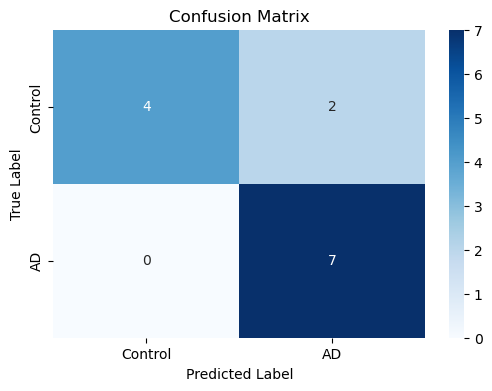

In [50]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

X = data.drop(columns=["label", "subject"])
y = data["label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=90, stratify=y
)

print("\nTrain set shape:", X_train.shape)
print("Test set shape:", X_test.shape)
print("\nTrain label distribution:")
print(y_train.value_counts())
print("\nTest label distribution:")
print(y_test.value_counts())


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

clf = LogisticRegression(random_state=35, max_iter=1000)
clf.fit(X_train_scaled, y_train)

y_pred = clf.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
print("\nAccuracy:", accuracy)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=["Control", "AD"], yticklabels=["Control", "AD"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

## Model 2

We utilized a random forest to make our predictions on whether someone is a healthy patient or a patient with Alzheimers.

In [51]:
X = data.drop(columns=["label", "subject"])
y = data["label"]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=12
)

from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(random_state=20)
clf.fit(X_train, y_train)

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
y_pred = clf.predict(X_test)
report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

print(report) 
print(conf_matrix)
print(accuracy)

              precision    recall  f1-score   support

           0       0.75      1.00      0.86         6
           1       1.00      0.71      0.83         7

    accuracy                           0.85        13
   macro avg       0.88      0.86      0.85        13
weighted avg       0.88      0.85      0.84        13

[[6 0]
 [2 5]]
0.8461538461538461


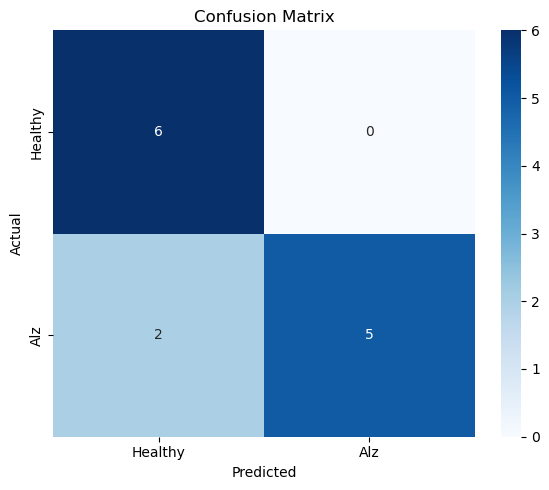

In [52]:
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Healthy", "Alz"], yticklabels=["Healthy", "Alz"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()